In [1]:
from scipy.stats import entropy
import pandas
import numpy
from tqdm import tqdm
import sys
import seaborn
import matplotlib
pandas.set_option('display.max_columns', None)
from tqdm.notebook import trange, tqdm
from time import sleep
import numpy
from joblib import Parallel, delayed
seaborn.set_palette("Paired")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import subprocess
import os.path

In [2]:
OUTPUT_IMAGE_PATH = "./../report/fragments/05_workhorse_experiment/images/"

In [3]:
def instanciate_runner(executable_path, input_path="./", output_path="/tmp"):

    if os.path.exists(executable_path):
        def execute_experiment( input_file:str, input_size:int, extractions:int, output_file:str = None, generate_dataframe=False, enable_reuse=0,
                                log_pivot_time = 0, log_iteration_time = 0, log_extraction_time = 0, log_swaps = 0, use_random_pivot = 0,
                                use_bfprt = 0, use_iiqs = 0, set_bfprt_alpha = 0.3, set_bfprt_beta = 0.7, set_random_seed = 42, 
                                set_pivot_bias = 0.5, set_redundant_bias = 0.5, thread_id="" ):
            if output_file == None:
                output_file = input_file.split("/")[-1]
            arguments = [
            ('--log-iteration-time=' + str(log_iteration_time)),
            ('--log-pivot-time=' + str(log_iteration_time)),
            ('--log-swaps=' + str(log_iteration_time)),
            ('--log-extraction-time=' + str(log_extraction_time)),
            ('--enable-reuse=' + str(enable_reuse)),
            ('--use-bfprt=' + str(use_bfprt)),
            ('--use-iiqs=' + str(use_iiqs)),
            ('--set-bfprt-alpha=' + str(set_bfprt_alpha)),
            ('--set-bfprt-beta=' + str(set_bfprt_beta)),
            ('--use-random-pivot=' + str(use_random_pivot)),
            ('--set-random-seed=' + str(set_random_seed)),
            ('--set-pivot-bias=' + str(set_pivot_bias)),
            ('--set-redundant-bias=' + str(set_redundant_bias)),
            ('--input-file=' + '/'.join([input_path, str(input_file)])),
            ('--output-file=' + '/'.join([output_path, str(output_file + thread_id)])),
            ('--input-size=' + str(input_size)),
            ('--extractions=' + str(extractions))]
            #print(" ".join([''+executable_path] + arguments))
            result = subprocess.run(" ".join([''+executable_path] + arguments), shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            #print(result.stdout.decode('utf-8'))
            #print(result.stderr.decode('utf-8'))
            return pandas.read_csv('/'.join([output_path, str(output_file + thread_id)]))
        return execute_experiment
    else:
        return None

In [4]:
#runner = instanciate_runner('/home/kuky_nekoi/magicode/program/base_benchmark/main')
runner = instanciate_runner('/home/kuky_nekoi/Documents/Sources/KuKy_NeKoi/magicode/program/base_benchmark/main_prototype',
                            input_path='/home/kuky_nekoi/Documents/Sources/KuKy_NeKoi/magicode/experiments/01_base_benchmark_data')

In [5]:
N = 10**4
pivot_bias = 0.0

dataframes = []

datasets = ['random/N_6.fold_1.ascii', 'sorted_decreasing/N_6.ascii', 'sorted_increasing/N_6.ascii']
algorithms = [0,1,2]

for dataset in datasets:
    for algorithm in algorithms:
        #if algorithm == 1:
        df = runner(dataset, N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0, 
                    set_pivot_bias=pivot_bias, use_iiqs=algorithm, use_bfprt=1)
        #else:
        #    df = runner(dataset, N, N, 
        #                generate_dataframe=True,
        #                log_extraction_time=1,
        #                set_redundant_bias=0, 
        #                set_bfprt_alpha=0.4,
        #                set_bfprt_beta=0.65,
        #                set_pivot_bias=pivot_bias, use_iiqs=algorithm, use_bfprt=1)
        dataframes.append(df)
        
result_df = pandas.concat(dataframes)

In [6]:
import plotting

In [7]:
result_df["param.use_iiqs"] = result_df["param.use_iiqs"].apply(lambda x: plotting.characterize_algorithm(x) )

result_df["param.set"] = result_df["input_file_value"].apply(lambda x: x.split("/")[-2] )

result_df["hue"] = result_df["param.use_iiqs"] + " " + result_df["param.set"]

In [8]:
plot_df = result_df[  result_df["snapshot.snapshot_point"] == "EXTRACTION_STAGE_END"]
plot_df_sorted_inc = plot_df[plot_df["param.set"] == "sorted_increasing"]
plot_df_sorted_dec = plot_df[plot_df["param.set"] == "sorted_decreasing"]
plot_df_random = plot_df[plot_df["param.set"] == "random"]

In [9]:
def extract_subplot__(axis, main_figure, path):
    extent = axis.get_window_extent().transformed(main_figure.dpi_scale_trans.inverted())
    main_figure.savefig(path + ".png", bbox_inches=extent)
    main_figure.savefig(path + ".expanded.png", bbox_inches=extent.expanded(1.1, 1.1))
    
def extract_subplot(axis, main_figure, path):
    bbox = axis.get_tightbbox(main_figure.canvas.get_renderer())
    main_figure.savefig(path + ".png",
          bbox_inches=bbox.transformed(main_figure.dpi_scale_trans.inverted()).expanded(1.1, 1.1))
    
def segregate_plot(filename, tag, title, plotter, **args):
    original_return = None
    if "ax" in args:
        original_return = plotter(**args)
        if title is not None:
            original_return.set_title(title)
    
    fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(8,8))
    
    axes.set(xscale=args["ax"].get_xscale())
    axes.set(yscale=args["ax"].get_yscale())
    args["ax"] = axes
    plot = plotter(**args)
    if title is not None:
        plot.set_title(title)
    fig.savefig(filename + "." + tag + ".png")
    return original_return
    

In [10]:
def plot_base_benchmark(dataframe, output_file, size=(16, 24), prepend="" ):
    
    fig, axes = matplotlib.pyplot.subplots(nrows=3, ncols=2, figsize=size)
    destination = OUTPUT_IMAGE_PATH + output_file
    
    segregate_plot(destination, "0_0", prepend + "Cumulated extraction time", seaborn.lineplot, x="snapshot.current_extraction", y="snapshot.total_extraction_time", 
                    data=dataframe, ax=axes[0,0], hue="param.use_iiqs")
    
    
    segregate_plot(filename=destination, tag="1_0", title=prepend + "Extraction time distribution", plotter=seaborn.scatterplot, x="snapshot.current_extraction", y="snapshot.extraction_time", 
                    data=dataframe, linewidth=0, alpha=0.5, ax=axes[1,0], hue="param.use_iiqs")
    
    
    segregate_plot(filename=destination, tag="2_0", title=prepend + "Stack size per extraction", plotter=seaborn.scatterplot, x="snapshot.current_extraction", y="snapshot.current_stack_size", 
                    data=dataframe, linewidth=0, alpha=0.5, ax=axes[2,0], hue="param.use_iiqs")

    plot_df_head = dataframe[ (dataframe["snapshot.current_extraction"] < 1000)]
    
    #fix for logplot
    #plot_df_head["snapshot.extraction_time"] = plot_df_head["snapshot.extraction_time"].apply(lambda x: x+0.1)
    #plot_df_head["snapshot.current_stack_size"] = plot_df_head["snapshot.current_stack_size"].apply(lambda x: x+0.1)
    #display(plot_df_head["snapshot.current_stack_size"].describe())
    
    axes[0,1].set(yscale="symlog")
    axes[1,1].set(yscale="symlog")
    axes[2,1].set(yscale="symlog")

    segregate_plot(filename=destination, tag="0_1", title=prepend + "Cumulated extraction time", plotter=seaborn.lineplot, x="snapshot.current_extraction", y="snapshot.total_extraction_time", 
                    data=plot_df_head, ax=axes[0,1], hue="param.use_iiqs")
    
    segregate_plot(filename=destination, tag="1_1", title=prepend + "Extraction time distribution", plotter=seaborn.scatterplot, x="snapshot.current_extraction", y="snapshot.extraction_time", 
                    data=plot_df_head, linewidth=0, alpha=0.5, ax=axes[1,1], hue="param.use_iiqs")
    
    segregate_plot(filename=destination, tag="2_1", title=prepend + "Stack size per extraction", plotter=seaborn.scatterplot, x="snapshot.current_extraction", y="snapshot.current_stack_size", 
                    data=plot_df_head, linewidth=0, alpha=0.5, ax=axes[2,1], hue="param.use_iiqs")
    
    fig.savefig(destination)
    

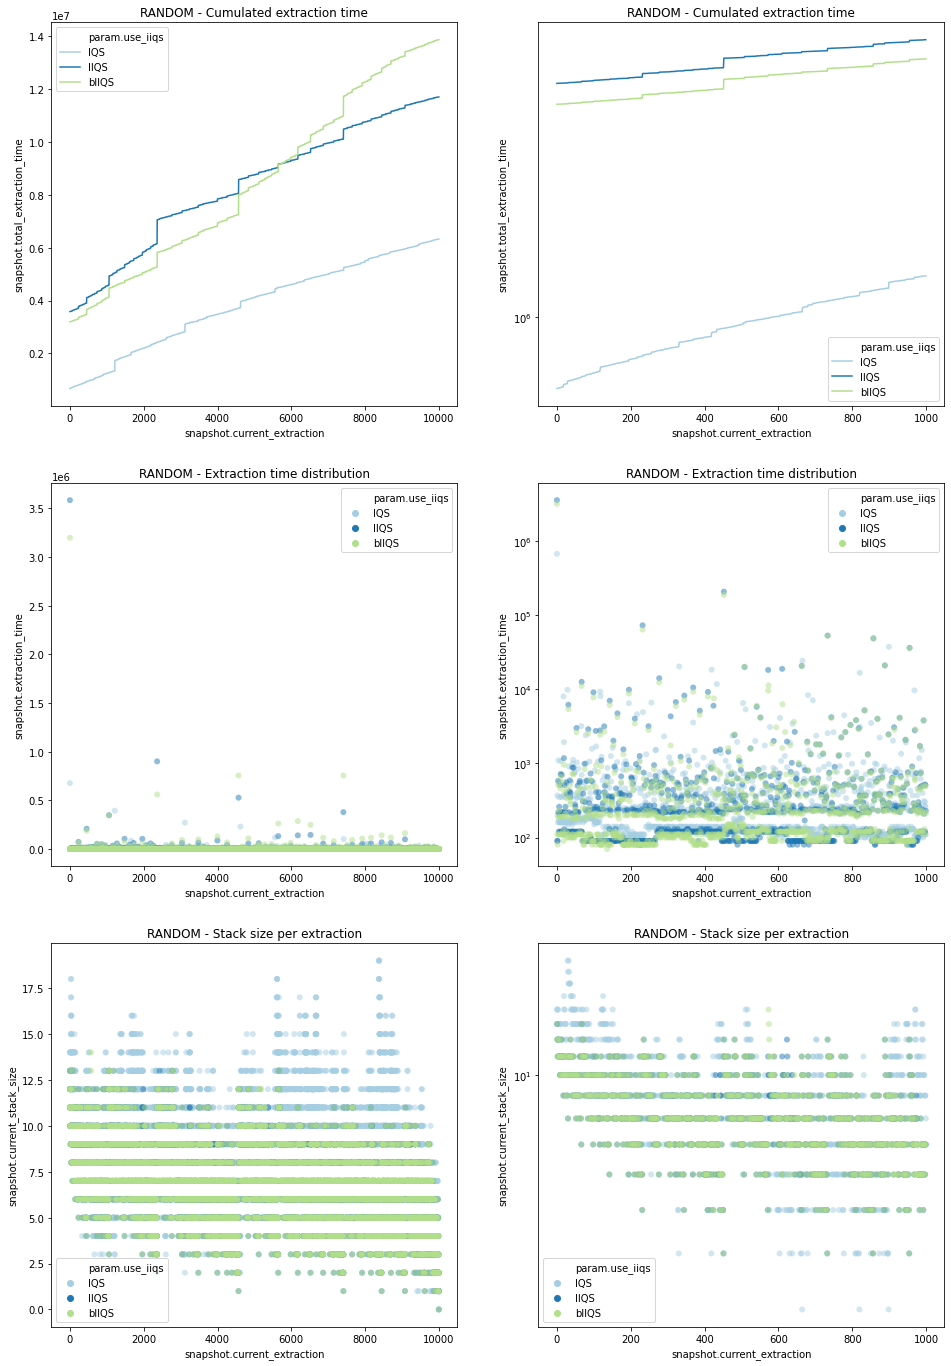

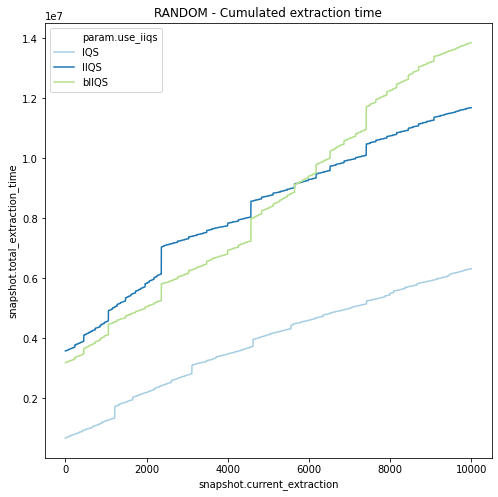

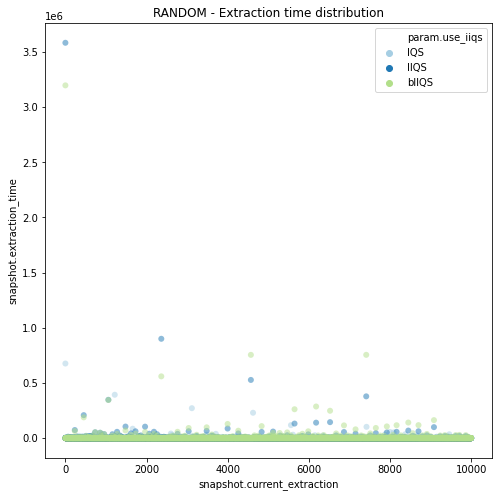

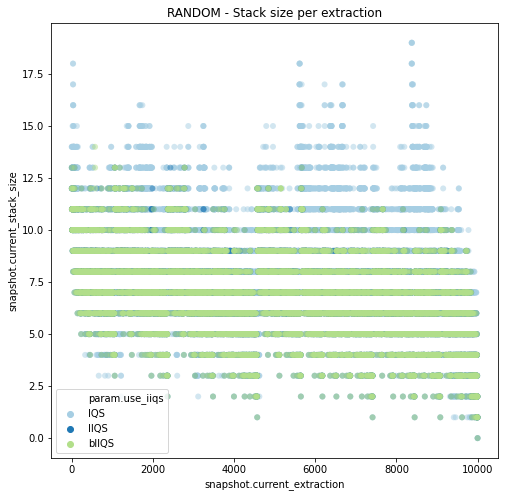

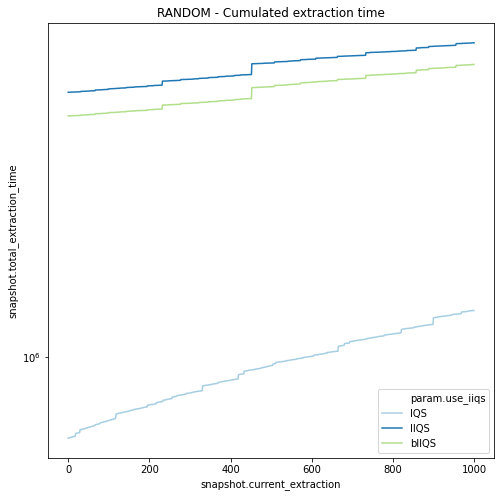

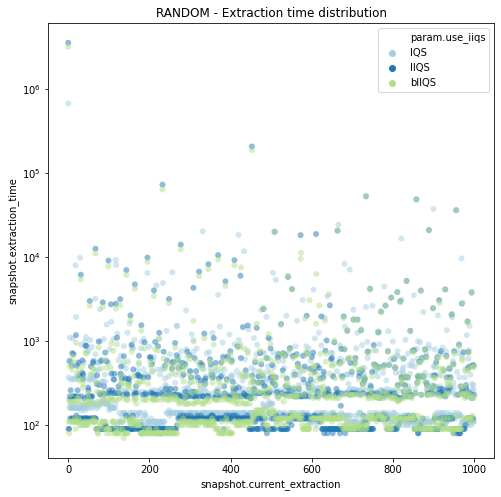

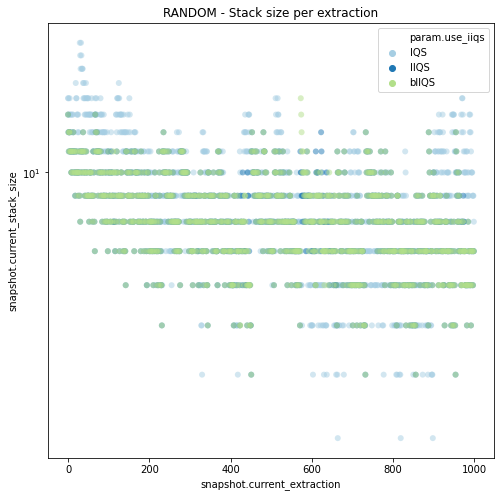

In [11]:
plot_base_benchmark(plot_df_random, "01_basebenchmark_01_random_case.png", prepend="RANDOM - ")

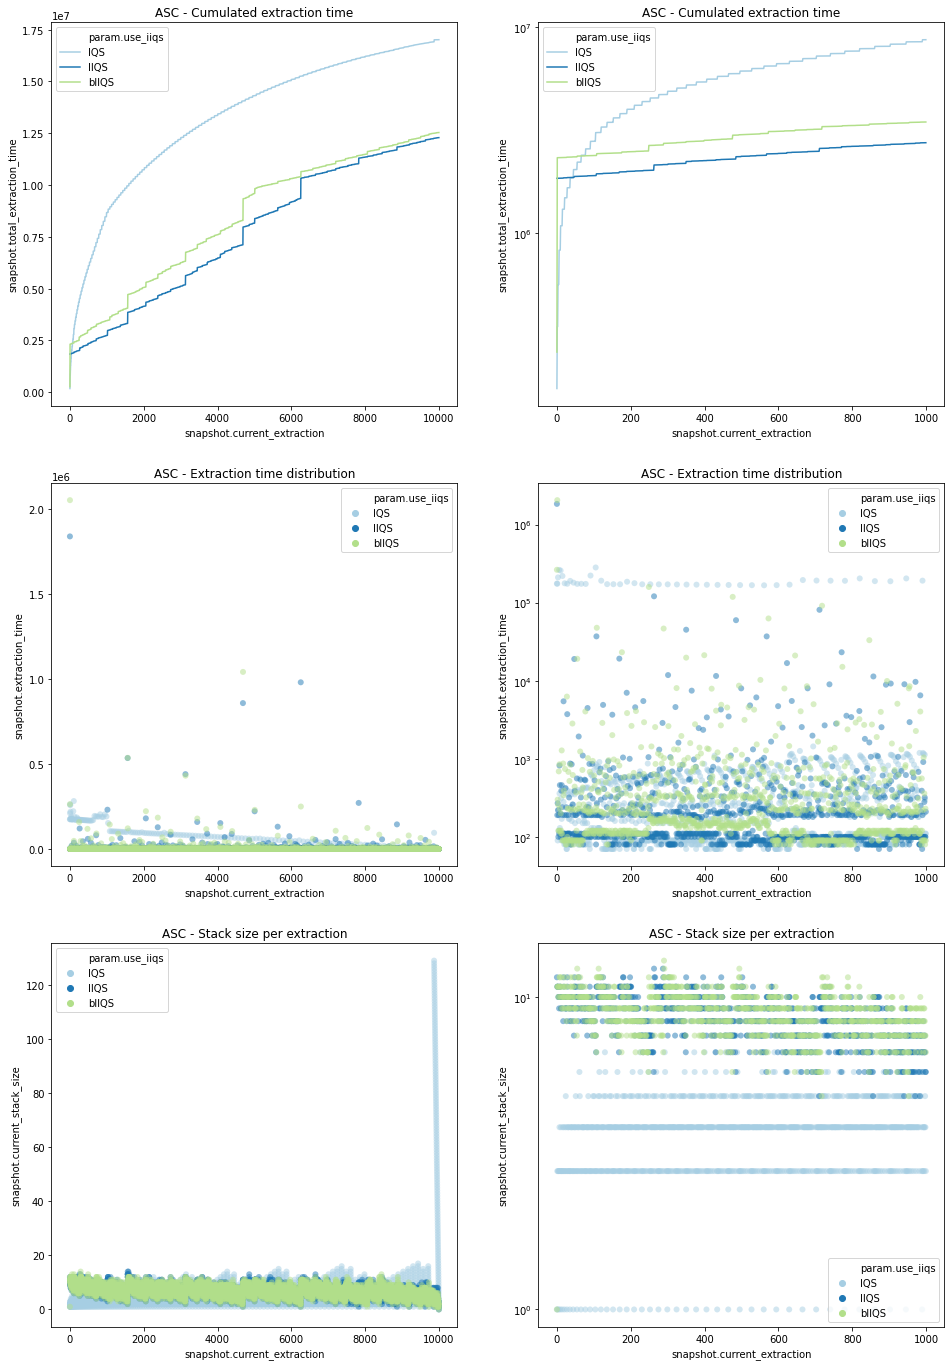

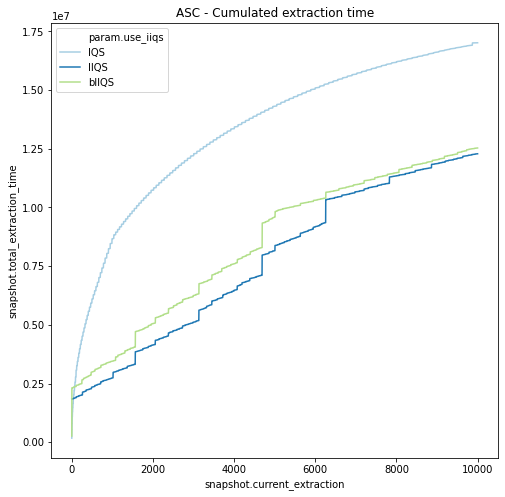

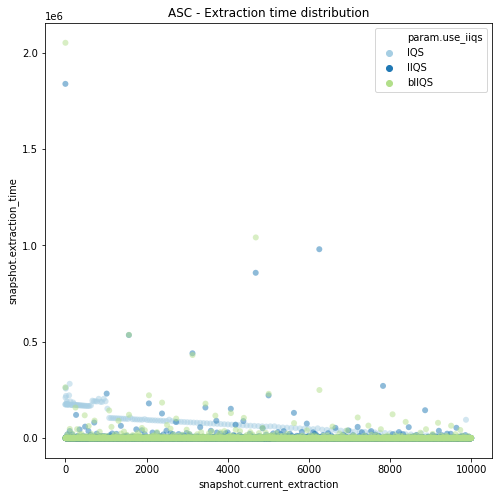

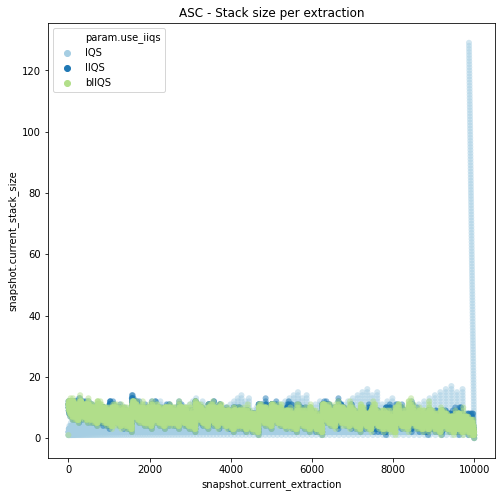

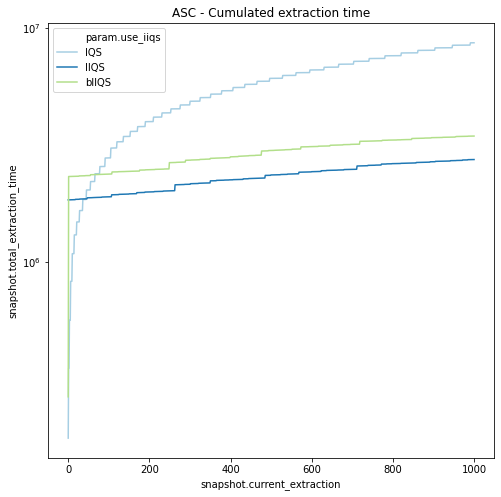

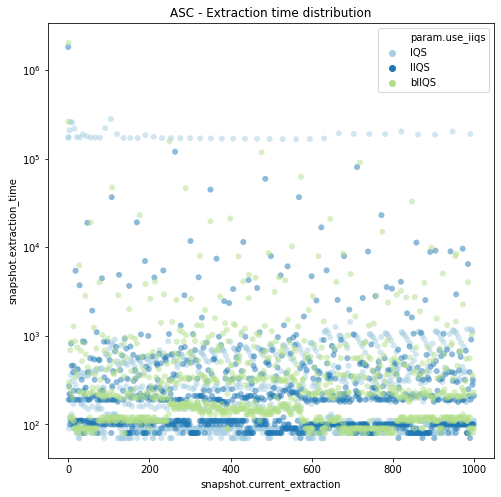

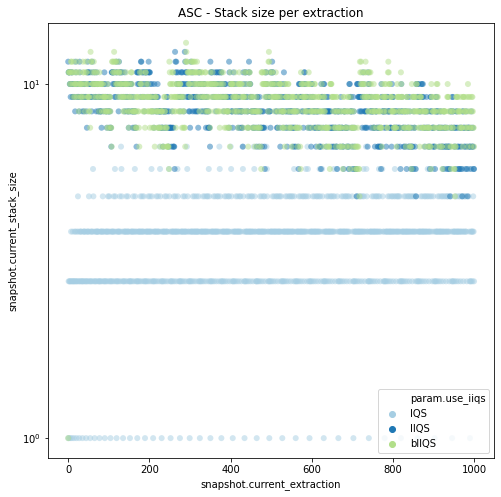

In [12]:
plot_base_benchmark(plot_df_sorted_inc, "01_basebenchmark_02_sort_a_case.png", prepend="ASC - ")

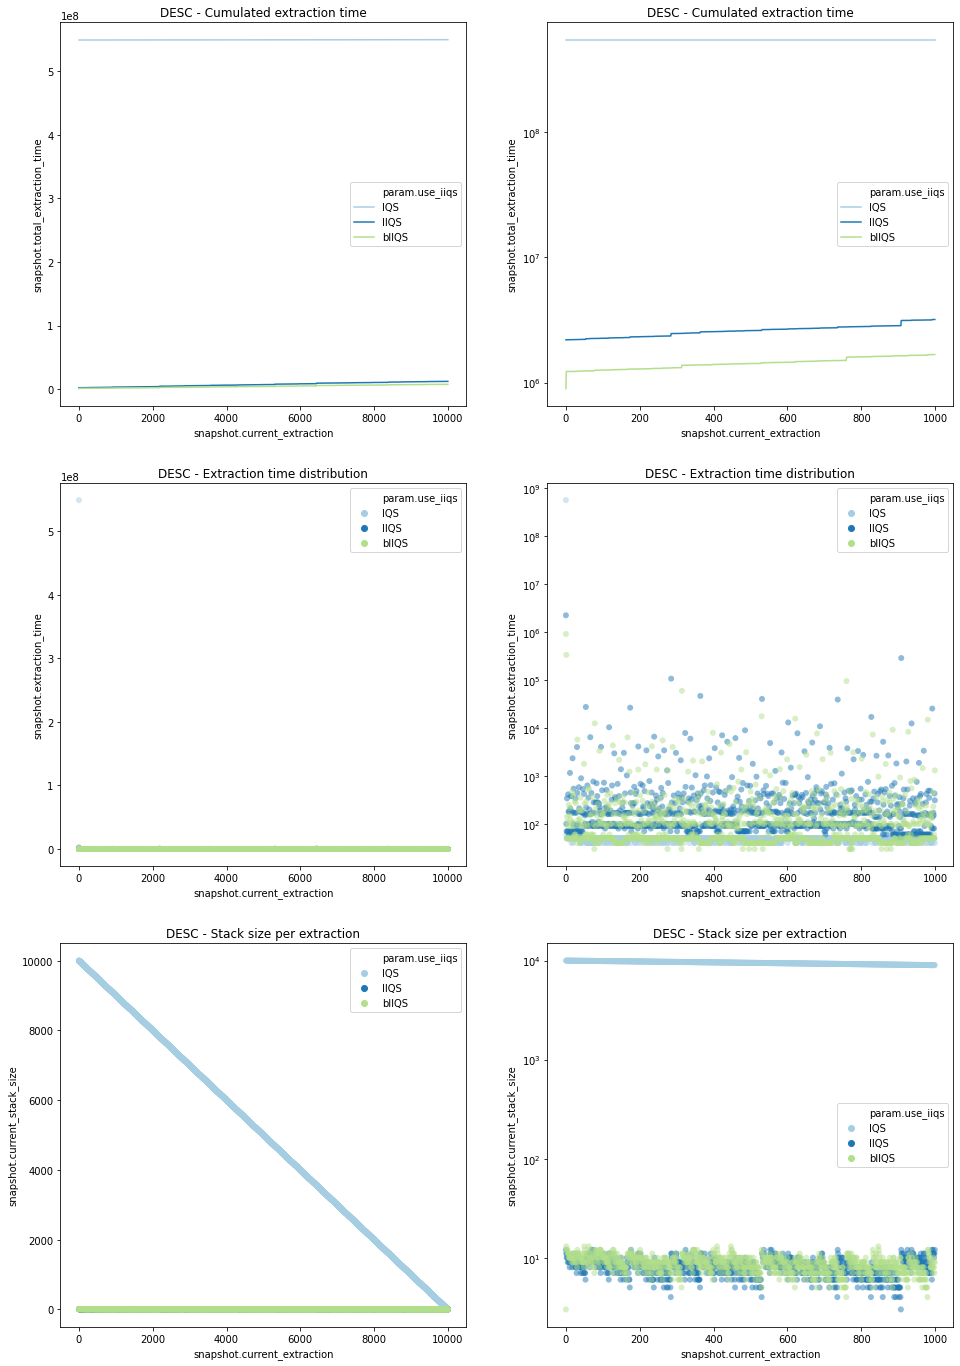

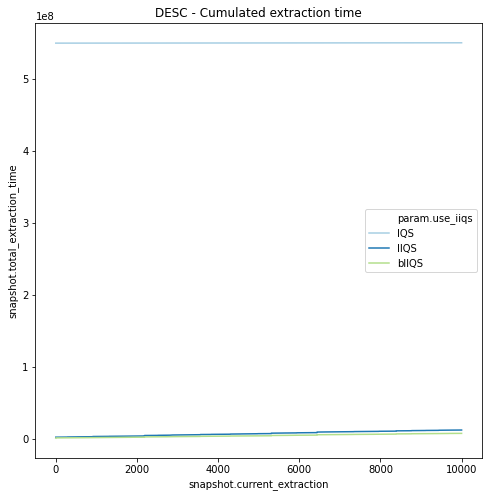

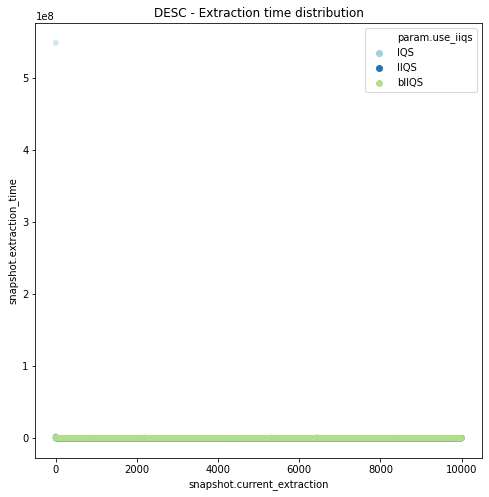

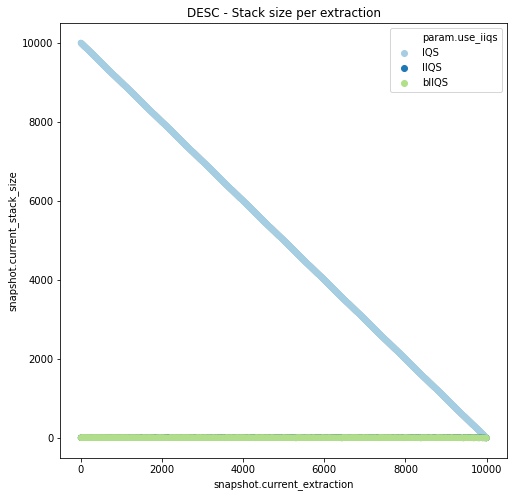

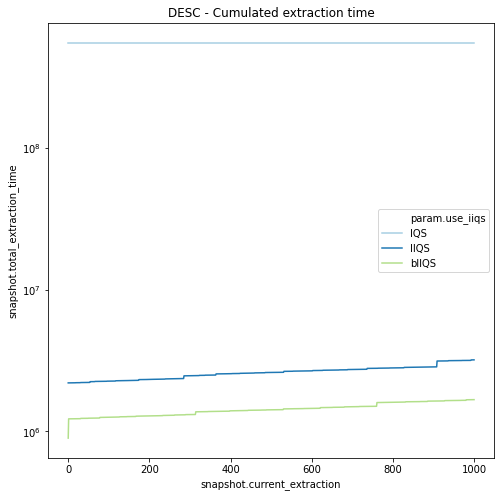

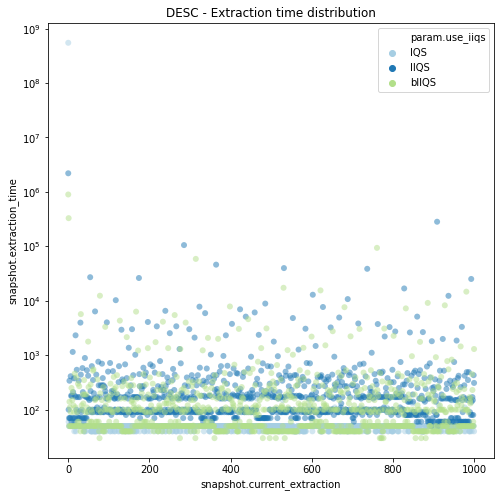

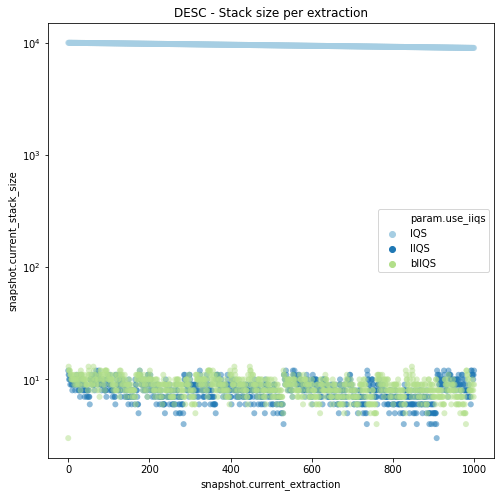

In [13]:
plot_base_benchmark(plot_df_sorted_dec, "01_basebenchmark_03_sort_d_case.png", prepend="DESC - ")
    

In [14]:
N = 10**4
pivot_bias = 0.0
redundant_bias = 1.0

result_iiqs = runner('bins/N_4_R_0_C_1.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias, use_iiqs=1, use_bfprt=1, set_redundant_bias=redundant_bias)

result_iqs = runner('bins/N_4_R_0_C_1.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias, use_iiqs=0, set_redundant_bias=redundant_bias)

result_riiqs = runner('bins/N_4_R_0_C_1.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias, use_iiqs=2, set_redundant_bias=redundant_bias)

In [15]:
result_df = pandas.concat([result_iqs, result_iiqs, result_riiqs])
result_df["param.use_iiqs"] = result_df["param.use_iiqs"].apply(lambda x: plotting.characterize_algorithm(x) )
result_df["param.set"] = result_df["input_file_value"].apply(lambda x: x.split("/")[-2] )
result_df["hue"] = result_df["param.use_iiqs"] + " " + result_df["param.set"]

In [16]:
result_riiqs

index  param.log_pivot_time  param.log_iteration_time  \
0         0                     0                         0   
1         1                     0                         0   
2         2                     0                         0   
3         3                     0                         0   
4         4                     0                         0   
...     ...                   ...                       ...   
9995   9995                     0                         0   
9996   9996                     0                         0   
9997   9997                     0                         0   
9998   9998                     0                         0   
9999   9999                     0                         0   

      param.log_extraction_time  param.log_swaps  param.use_bfprt  \
0                             1                0                0   
1                             1                0                0   
2                             1                0                0   
3                             1                0                0   
4                             1                0                0   
...                         ...              ...              ...   
9995                          1                0                0   
9996                          1                0                0   
9997                          1                0                0   
9998                          1                0                0   
9999                          1                0                0   

      param.use_iiqs  param.use_dutch_flag  param.use_random_pivot  \
0                  2                     1                       0   
1                  2                     1                       0   
2                  2                     1                       0   
3                  2                     1                       0   
4                  2                     1                       0   
...              ...                   ...                     ...   
9995               2                     1                       0   
9996               2                     1                       0   
9997               2                     1                       0   
9998               2                     1                       0   
9999               2                     1                       0   

      param.enable_reuse  alpha_value  param.beta_value  param.pivot_bias  \
0                      0          0.3               0.7                 0   
1                      0          0.3               0.7                 0   
2                      0          0.3               0.7                 0   
3                      0          0.3               0.7                 0   
4                      0          0.3               0.7                 0   
...                  ...          ...               ...               ...   
9995                   0          0.3               0.7                 0   
9996                   0          0.3               0.7                 0   
9997                   0          0.3               0.7                 0   
9998                   0          0.3               0.7                 0   
9999                   0          0.3               0.7                 0   

      param.redundant_bias  random_seed_value  input_size  param.extractions  \
0                        1                 42       10000              10000   
1                        1                 42       10000              10000   
2                        1                 42       10000              10000   
3                        1                 42       10000              10000   
4                        1                 42       10000              10000   
...                    ...                ...         ...                ...   
9995                     1                 42       10000              10000   
9996          

In [17]:
result_df["param.use_iiqs"].describe()

count     30000
unique        3
top       bIIQS
freq      10000
Name: param.use_iiqs, dtype: object

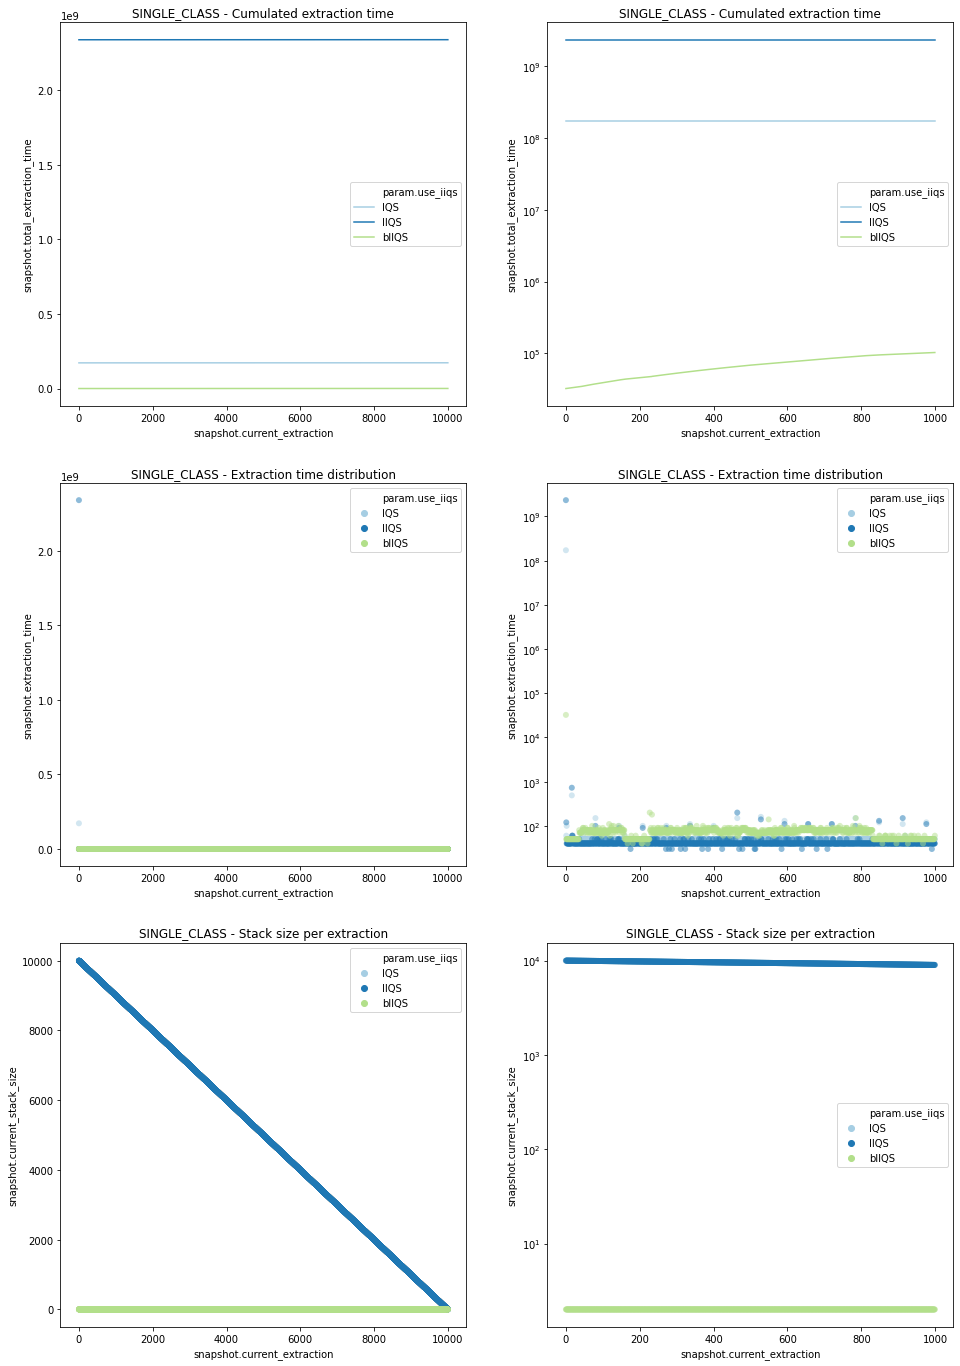

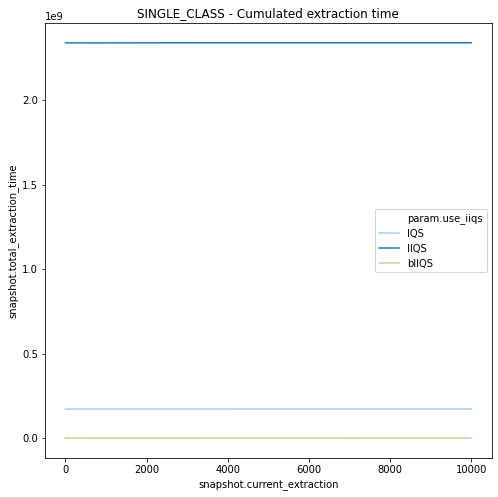

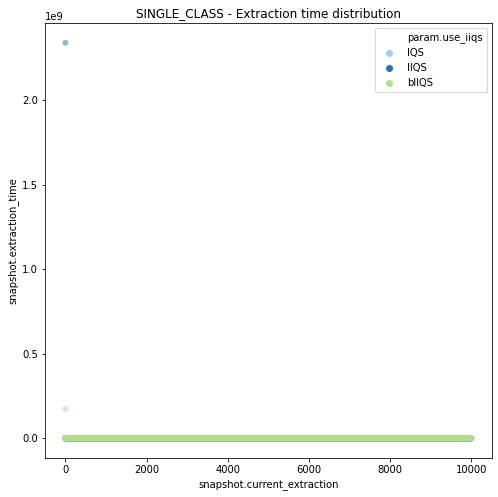

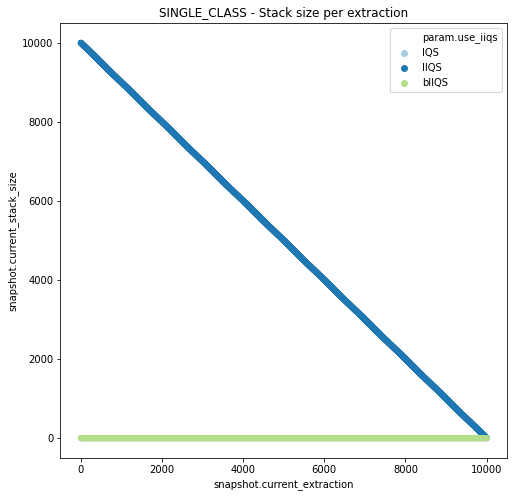

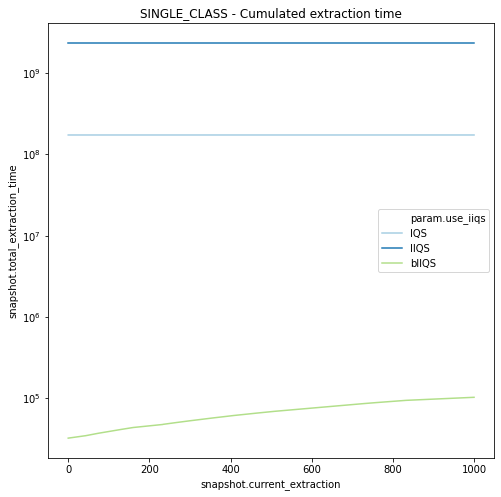

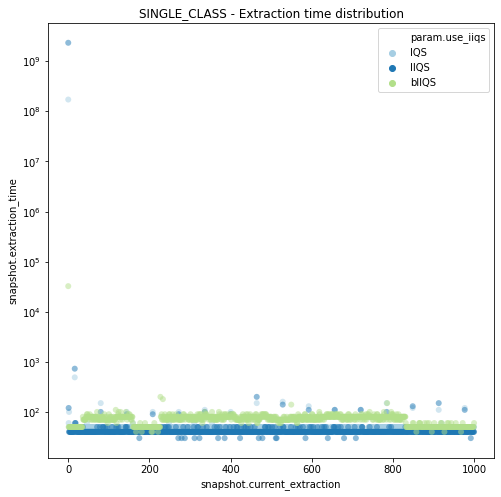

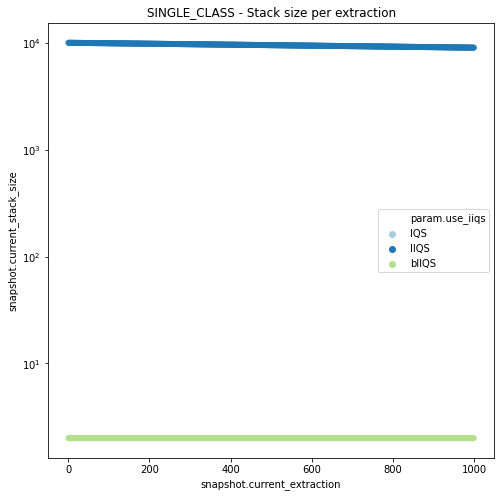

In [18]:
plot_df_one_class = result_df[result_df["snapshot.snapshot_point"] == "EXTRACTION_STAGE_END"]

plot_base_benchmark(plot_df_one_class, "01_basebenchmark_04_single_class.png", prepend="SINGLE_CLASS - ")

In [19]:
def parallel_riiqs(filename, classes=0, noise=0, alpha=0.3, algorithm=2, beta=0.7, extractions=10, tid="", postprocess=None, redundant_bias_param = 1, pivot_bias_param = 0):
    alpha = numpy.round(alpha,7)
    beta = numpy.round(beta,7)
    print("parallel_iiqs(alpha={}, beta={}, filename={}, extractions={})".format(alpha, beta, filename, extractions))
    result_riiqs = runner(filename, n, extractions, 
                        generate_dataframe=True,
                        log_extraction_time=1,
                        set_pivot_bias=pivot_bias_param, use_iiqs=algorithm, 
                        use_bfprt=1, set_redundant_bias=redundant_bias_param,
                        set_bfprt_alpha=alpha, set_bfprt_beta=beta, 
                        thread_id=tid)
    result_riiqs["experiment.classes"] = classes
    result_riiqs["experiment.noise"] = noise
    if postprocess:
        result_riiqs = postprocess(result_riiqs)
    return result_riiqs


In [20]:


def plot_3d_scatter(x,y,z, data, fig, bounds=(1,1,1,), preprocess=None, filters=[], title="",
                    logcolor=True, log_x=False, log_y=False, log_z=False,
                    invert_x=False, invert_y=False, invert_z=False,
                    projection="3d", proj_type = 'persp',
                    view_angle = None, s=100, alpha=1, base_output=None):
    #ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax = fig.add_subplot(bounds[0],bounds[1],bounds[2], projection=projection, proj_type = proj_type)
    
    fig_ =  matplotlib.pyplot.figure(figsize=(8,8))
    ax_ = fig_.add_subplot(1,1,1, projection=projection, proj_type = proj_type)
    
    sample = data
    
    if preprocess:
        sample = preprocess(sample)
    
    for custom_filter in filters:
        if custom_filter[1] == "eq":
            sample = sample[(sample[custom_filter[0]] == custom_filter[2])]  
        elif custom_filter[1] == "leq":
            sample = sample[(sample[custom_filter[0]] <= custom_filter[2])]  
        elif custom_filter[1] == "geq":
            sample = sample[(sample[custom_filter[0]] >= custom_filter[2])]  
        elif custom_filter[1] == "le":
            sample = sample[(sample[custom_filter[0]] < custom_filter[2])]  
        elif custom_filter[1] == "gt":
            sample = sample[(sample[custom_filter[0]] > custom_filter[2])]
    
    _x = sample[x]
    _y = sample[y]
    _z = sample[z]
    _c = _z
    
    if logcolor:
       _c = numpy.log10(_z)
    
    if log_x:
        ax.xaxis.set_scale('log')
        ax_.xaxis.set_scale('log')
    if log_y:
        ax.yaxis.set_scale('log')
        ax_.yaxis.set_scale('log')
    if log_z:
        ax.zaxis.set_scale('log')
        ax_.zaxis.set_scale('log')
        
    if invert_x:
        ax.invert_xaxis()
        ax_.invert_xaxis()
    if invert_y:
        ax.invert_yaxis()
        ax_.invert_yaxis()
    if invert_z:
        ax.invert_zaxis()
        ax_.invert_zaxis()
    
    ax.scatter(_x, _y, _z, c=_c, cmap='rainbow',s=s, alpha=alpha)
    ax.set_xlim(min(_x), max(_x))
    ax.set_ylim(min(_y), max(_y))
    ax.set_zlim(min(_z), max(_z))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(title)
    
    if view_angle:
        ax.view_init(view_angle[0], view_angle[1])
        
    ax_.scatter(_x, _y, _z, c=_c, cmap='rainbow',s=s, alpha=alpha)
    ax_.set_xlim(min(_x), max(_x))
    ax_.set_ylim(min(_y), max(_y))
    ax_.set_zlim(min(_z), max(_z))
    ax_.set_xlabel(x)
    ax_.set_ylabel(y)
    ax_.set_zlabel(z)
    ax_.set_title(title)
    
    if view_angle:
        ax_.view_init(view_angle[0], view_angle[1])
    
    column = bounds[2] % bounds[1]
    row = int(bounds[2] / bounds[0])
    
    if base_output is not None:
        fig_.savefig(base_output + ".{}_{}.png".format(column, row), bbox_inches='tight')
    

In [21]:
def plot_base_benchmark_3d(x,y,z, data, filters, title, file, s=100, alpha=1, algorithm_1=1, algorithm_2=2, 
                           algorithm_name_1="IIQS", algorithm_name_2="bIIQS",
                           default_filters_1 = [("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)],
                           default_filters_2 = [("param.use_iiqs", "eq", 2), ("snapshot.current_extraction", "eq", 1)]):
    fig = matplotlib.pyplot.figure(figsize=(16,24))

    destination = OUTPUT_IMAGE_PATH + file
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,1,), preprocess=None, filters=default_filters_1 + filters, 
                    title=algorithm_name_1 + " - " + title, s=s, alpha=alpha, base_output=destination)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,2,), preprocess=None, filters=default_filters_2 + filters, 
                    title=algorithm_name_2 + " - " + title, s=s, alpha=alpha, base_output=destination)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,3,), preprocess=None, filters=default_filters_1 + filters, 
                    title=algorithm_name_1 + " - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha, base_output=destination)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,4,), preprocess=None, filters=default_filters_2 + filters, 
                    title=algorithm_name_2 + " - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha, base_output=destination)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,5,), preprocess=None, filters=default_filters_1 + filters, 
                    title=algorithm_name_1 + " - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha, base_output=destination)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,6,), preprocess=None, filters=default_filters_2 + filters, 
                    title=algorithm_name_2 + " - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha, base_output=destination)

    fig.savefig(destination, bbox_inches='tight')
    
    ## Now, save them independly
    
    
    
    
def plot_stack_benchmark_3d(x,y,z, data, filters, title, file, s=100, alpha=1, z2=None):
    fig =  matplotlib.pyplot.figure(figsize=(16,24))
    
    max_extraction = data["snapshot.current_extraction"].max()
    
    if not z2:
        z2 = z

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,1,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z2, 
                    data=data, fig=fig,
                    bounds=(3,2,2,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,3,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z2, 
                    data=data, fig=fig,
                    bounds=(3,2,4,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,5,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z2, 
                    data=data, fig=fig,
                    bounds=(3,2,6,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    fig.savefig(OUTPUT_IMAGE_PATH + file, bbox_inches='tight')

In [22]:
N = 4
n = 10**N
pivot_bias = 0.0
redundant_bias = 1.0

dataframes = []

## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
classes_list = list([1] + list(range(increment_10p, n, increment_10p)))    
R = 0

In [23]:
classes_to_test  =[("bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(c) + ".fold_" + str(fold) + ".ascii", c) for c in classes_list]

In [24]:
riiqs_results = Parallel(n_jobs=10)( delayed(parallel_riiqs)(c[0], classes=c[1], noise=R, tid="{}".format(c[1]), algorithm=2, extractions=n) for c in classes_to_test )
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_riiqs)(c[0], classes=c[1], noise=R, tid="{}".format(c[1]), algorithm=1, extractions=n) for c in classes_to_test )

dataframes.extend(riiqs_results)
dataframes.extend(iiqs_results)
        
print("cat")    
result_df_grid = pandas.concat(dataframes)

cat


In [25]:
def log_column(column):
    def _lambda(df):
        df["log("+column+")"] = numpy.log10(df[column])
        return df
    return _lambda

result_df_grid = result_df_grid[(result_df_grid["snapshot.snapshot_point"] == "EXTRACTION_STAGE_END")]
result_df_grid = log_column('snapshot.extraction_time')(result_df_grid)

In [26]:
result_df_grid['snapshot.current_extraction']

0          0
1          1
2          2
3          3
4          4
        ... 
9995    9995
9996    9996
9997    9997
9998    9998
9999    9999
Name: snapshot.current_extraction, Length: 2000000, dtype: int64

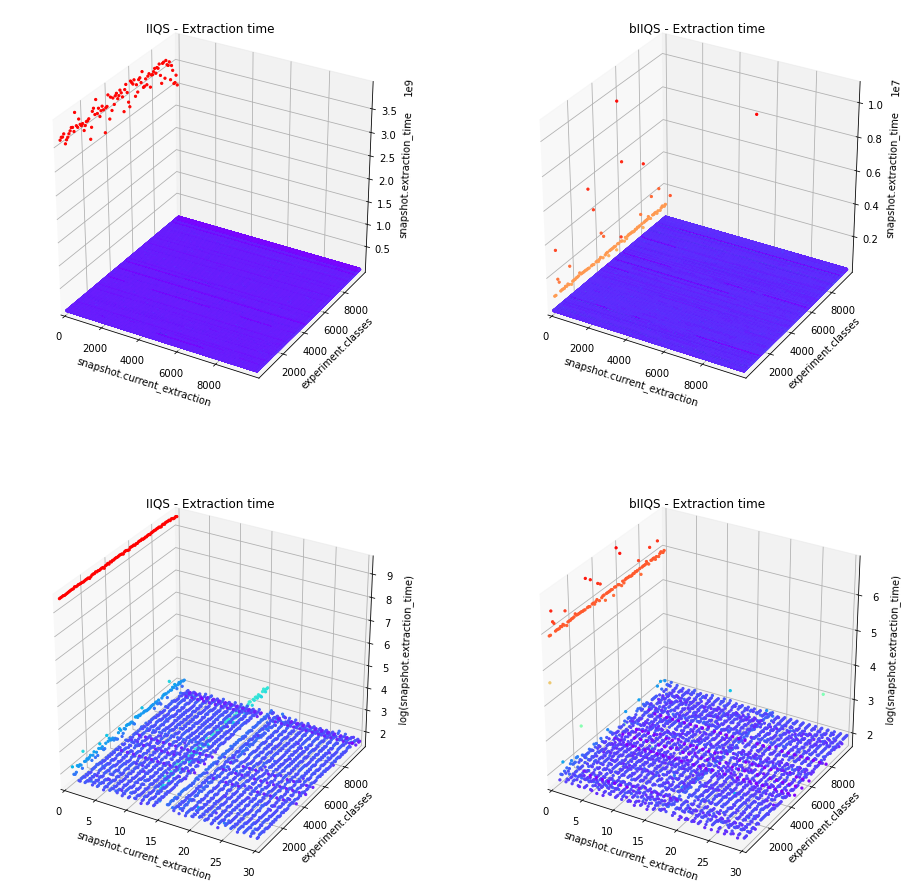

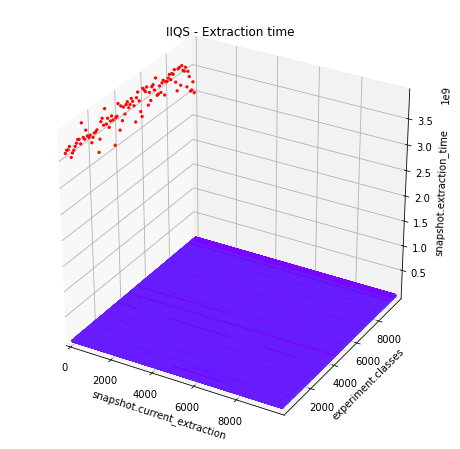

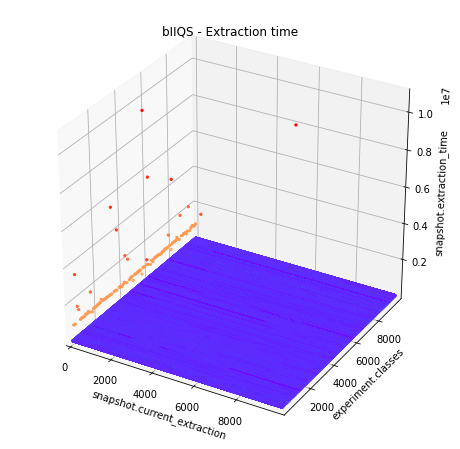

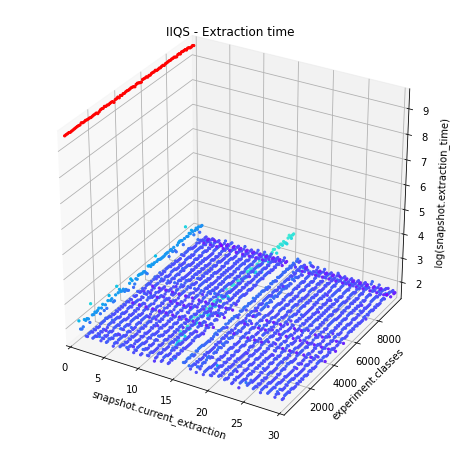

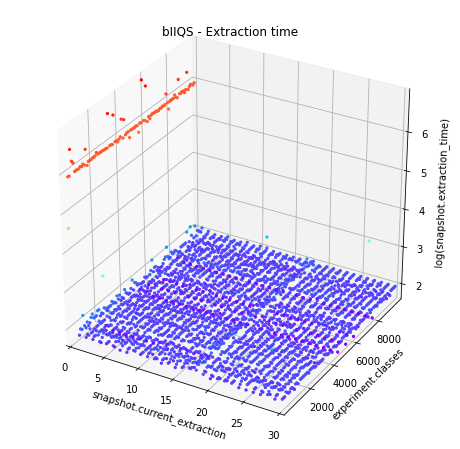

In [27]:

# Twice as wide as it is tall.
fig = matplotlib.pyplot.figure(figsize=(16,16))

destination_ = OUTPUT_IMAGE_PATH + "01_basebenchmark_05_classes.png"

plot_3d_scatter(x='snapshot.current_extraction',y='experiment.classes',z='snapshot.extraction_time', 
                data=result_df_grid, fig=fig,
                bounds=(2,2,1,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)],
                title="IIQS - Extraction time",s=5, base_output=destination_)
    
plot_3d_scatter(x='snapshot.current_extraction',y='experiment.classes',z='snapshot.extraction_time', 
                data=result_df_grid, fig=fig,
                bounds=(2,2,2,), preprocess=None, filters=[("param.use_iiqs", "eq", 2)],
                title="bIIQS - Extraction time",s=5, base_output=destination_)


plot_3d_scatter(x='snapshot.current_extraction',y='experiment.classes',z='log(snapshot.extraction_time)', 
                data=result_df_grid, fig=fig,
                bounds=(2,2,3,), preprocess=None, filters=[
                    ("param.use_iiqs", "eq", 1),
                    ("snapshot.current_extraction", "leq", 30)
                ],
                title="IIQS - Extraction time",s=5, base_output=destination_)
    
plot_3d_scatter(x='snapshot.current_extraction',y='experiment.classes',z='log(snapshot.extraction_time)', 
                data=result_df_grid, fig=fig,
                bounds=(2,2,4,), filters=[
                    ("param.use_iiqs", "eq", 2),
                    ("snapshot.current_extraction", "leq", 30)
                ], title="bIIQS - Extraction time",s=5, base_output=destination_)

fig.savefig(destination_, bbox_inches='tight')

In [28]:
N = 4
n = 10**N
extractions = 100
pivot_bias = 0.0
redundant_bias = numpy.arange(0.0, 1.0, 0.01)
noise_dataframes = []

## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
C = 1
R_range = list(range(0, n-1, increment_10p)) + [n-1]

for R in tqdm(R_range, desc="Noise level"):
    filename = "one_bin_noise/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
    
    iiqs_results = Parallel(n_jobs=10)( delayed(parallel_riiqs)(filename, classes=C, extractions=extractions, noise=R, algorithm=1, tid = "{}_{}_{}_{}".format(N,R,C,bias), redundant_bias_param=bias, pivot_bias_param=pivot_bias) for bias in redundant_bias)
    
    riiqs_results = Parallel(n_jobs=10)( delayed(parallel_riiqs)(filename, classes=C, extractions=extractions, noise=R, algorithm=2, tid = "{}_{}_{}_{}".format(N,R,C,bias), redundant_bias_param=bias, pivot_bias_param=pivot_bias) for bias in redundant_bias)
    
    noise_dataframes.extend(iiqs_results)
    noise_dataframes.extend(riiqs_results)
        
print("cat")    
result_df_noise_grid = pandas.concat(noise_dataframes)


cat


In [29]:
result_df_noise_grid = log_column('snapshot.extraction_time')(result_df_noise_grid)

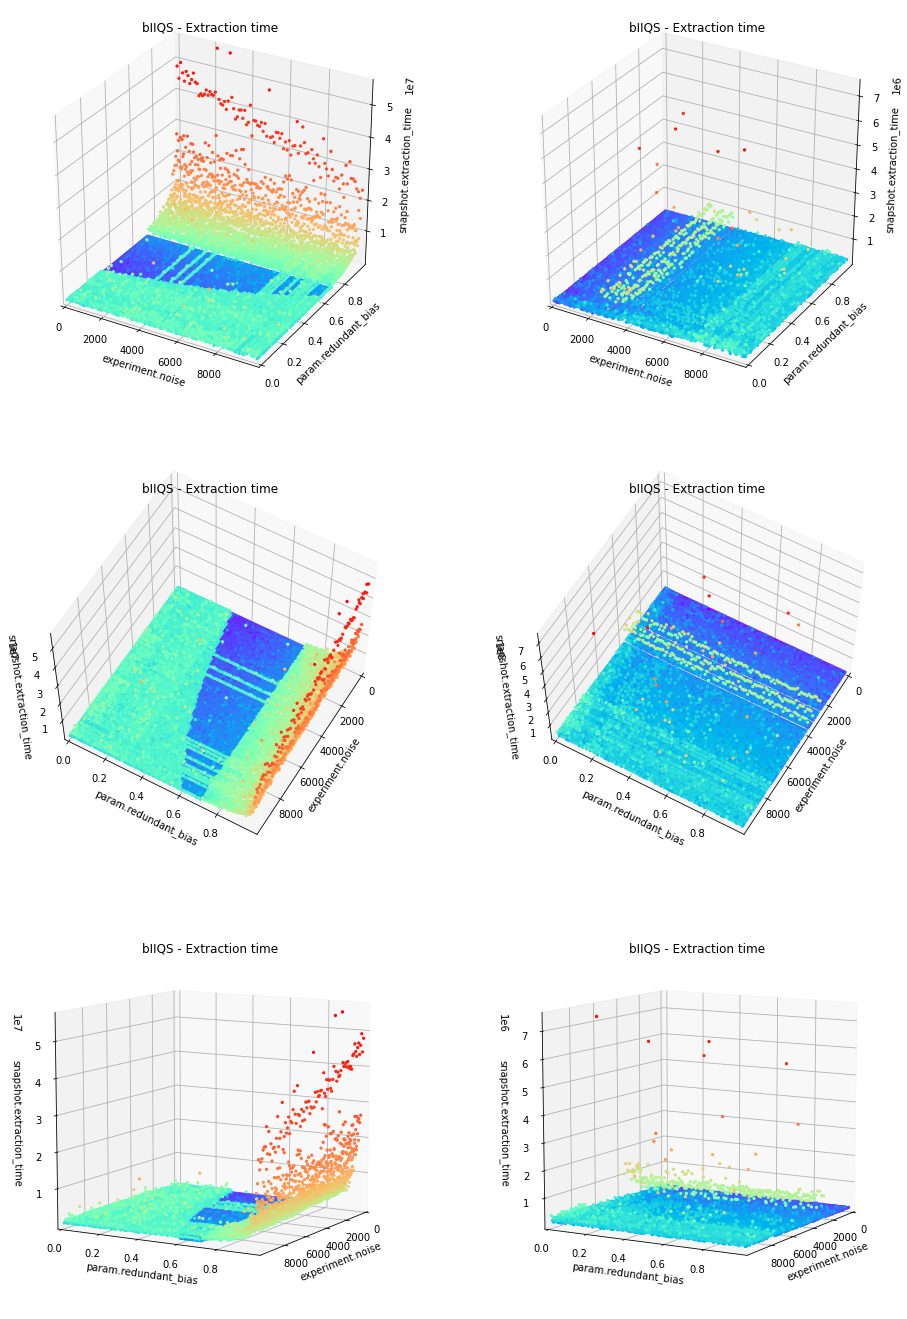

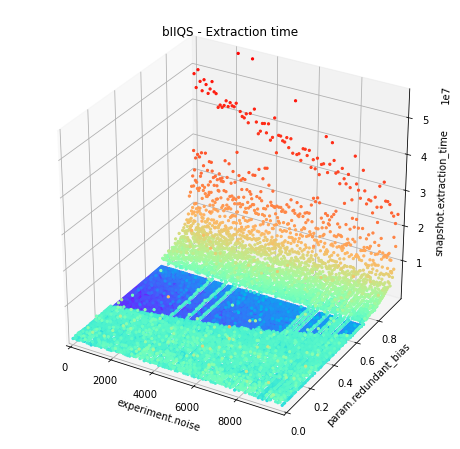

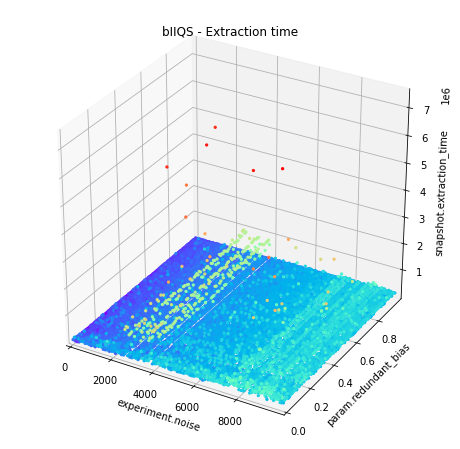

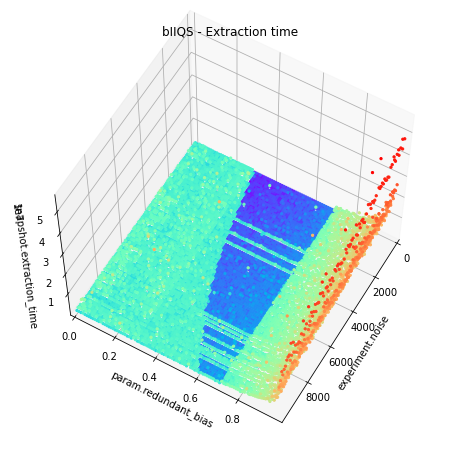

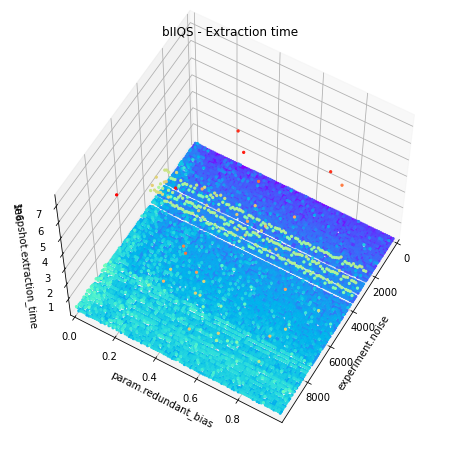

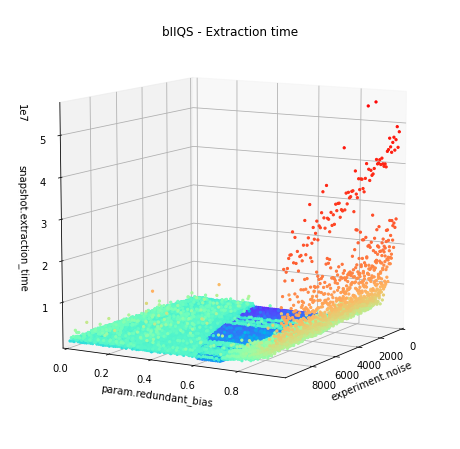

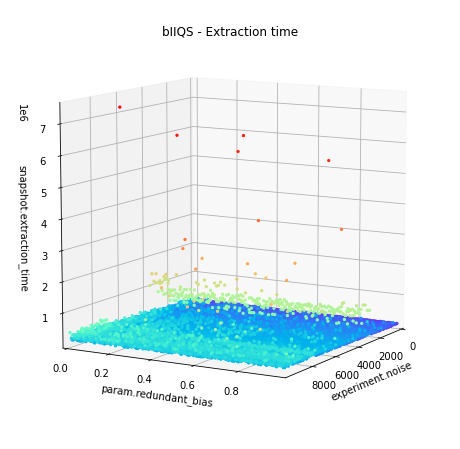

In [30]:
result_df_noise_grid = log_column('snapshot.extraction_time')(result_df_noise_grid)
result_df_noise_grid = result_df_noise_grid.sort_values(["snapshot.extraction_time"])

plot_base_benchmark_3d(x='experiment.noise',y='param.redundant_bias',z='snapshot.extraction_time',
                       algorithm_name_1="bIIQS", algorithm_1=1,
                       algorithm_name_2="bIIQS", algorithm_2=2,
                       default_filters_1=[("param.use_iiqs", "eq", 1)], default_filters_2=[("param.use_iiqs", "eq", 2)],
                       data=result_df_noise_grid, filters=[
                        ("snapshot.current_extraction", "eq", 0),
                    ], title="Extraction time", file="01_basebenchmark_06_noise_redundant_bias.png", s=5)

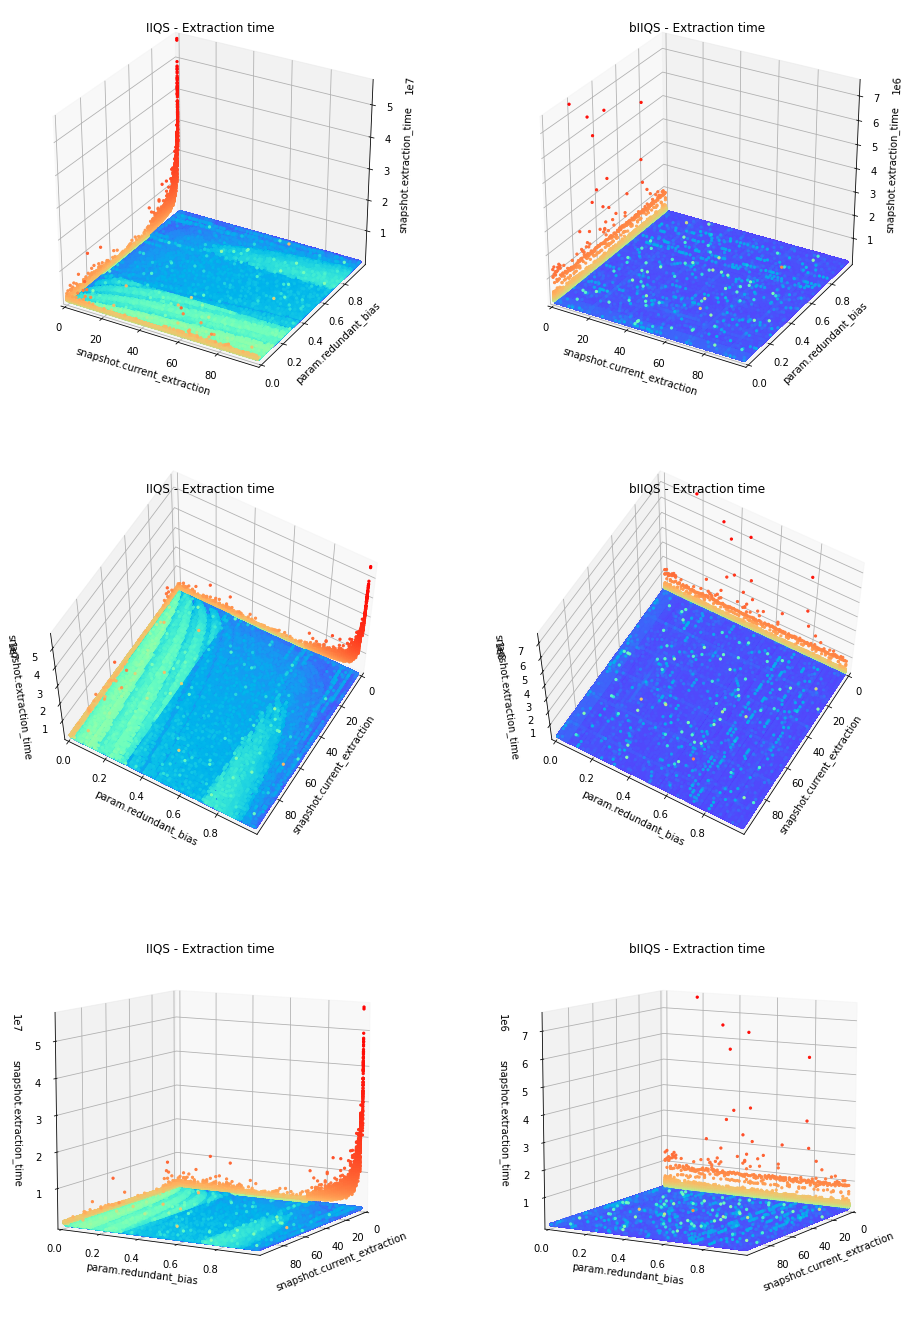

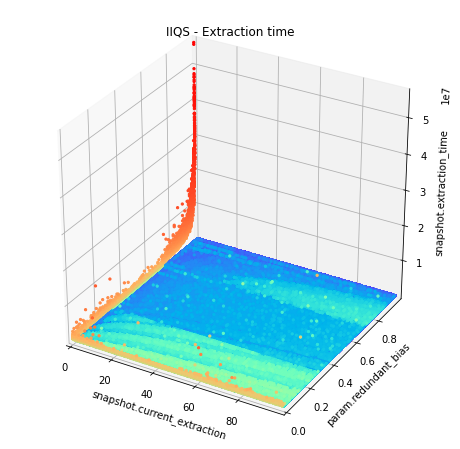

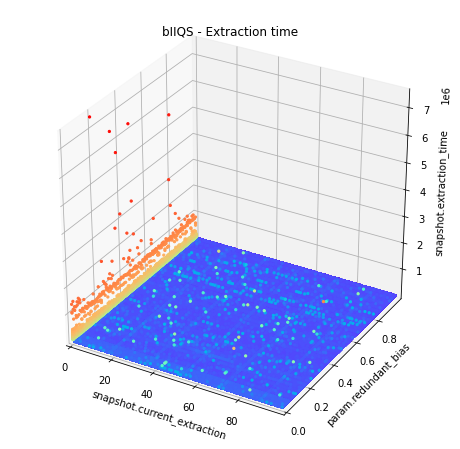

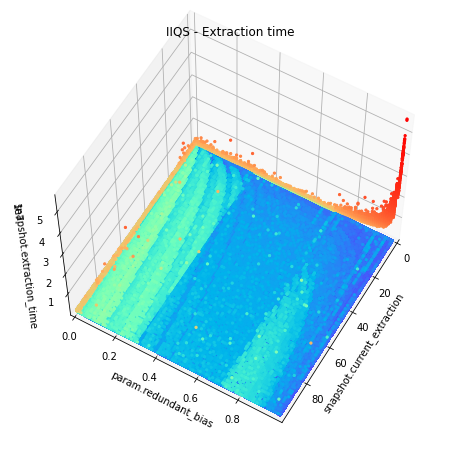

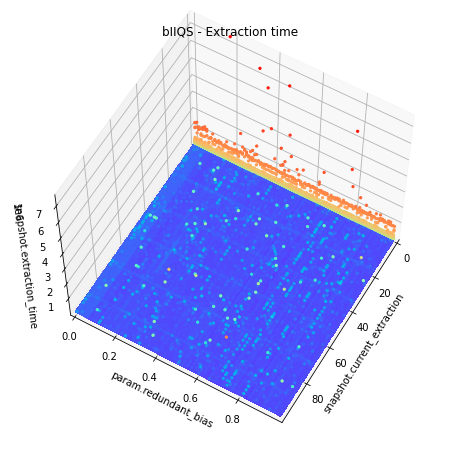

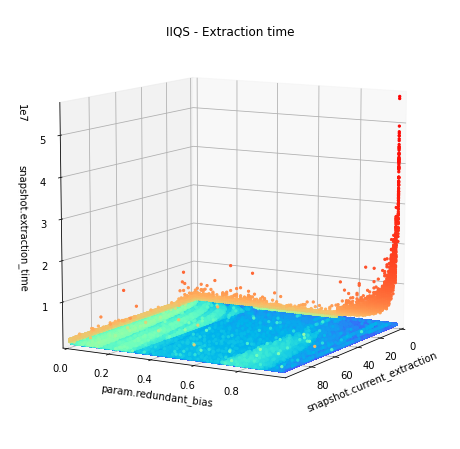

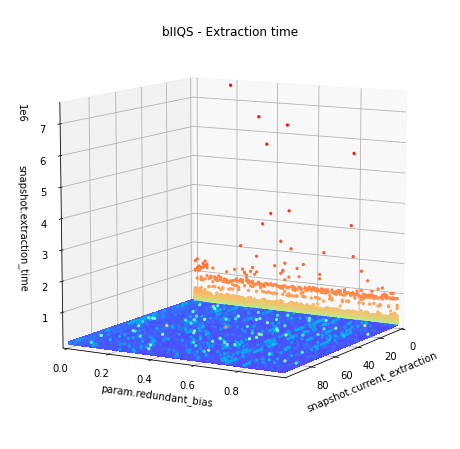

In [31]:
result_df_noise_grid = log_column('snapshot.extraction_time')(result_df_noise_grid)
result_df_noise_grid = result_df_noise_grid.sort_values(["snapshot.extraction_time"])

plot_base_benchmark_3d(x='snapshot.current_extraction',y='param.redundant_bias',z='snapshot.extraction_time',
                       algorithm_name_1="IIQS", algorithm_1=1,
                       algorithm_name_2="bIIQS", algorithm_2=2,
                       filters=[("snapshot.current_extraction", "leq", 100)],
                       default_filters_1=[("param.use_iiqs", "eq", 1)], 
                       default_filters_2=[("param.use_iiqs", "eq", 2)],
                       data=result_df_noise_grid, title="Extraction time", file="01_basebenchmark_06_redundant_bias.png", s=5)

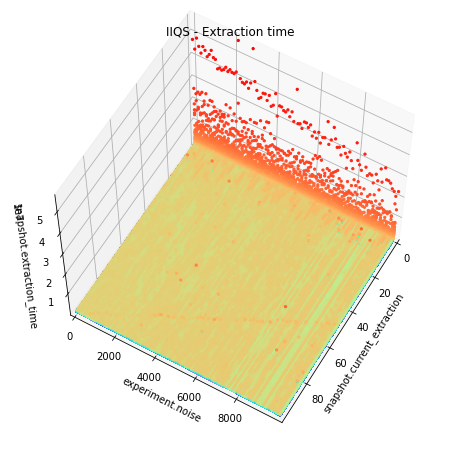

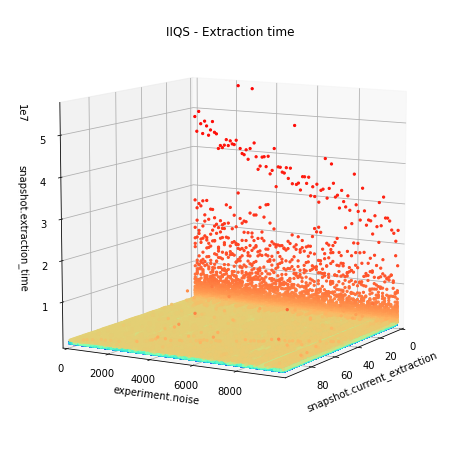

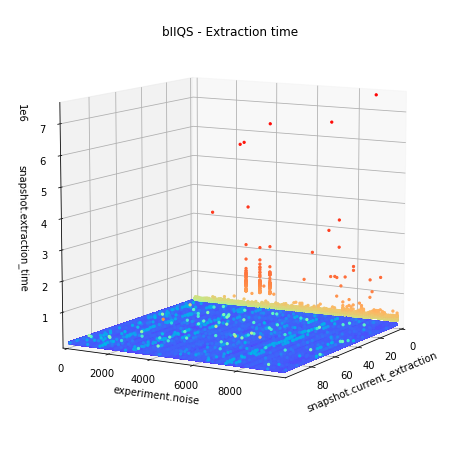

In [32]:
result_df_noise_grid = log_column('snapshot.extraction_time')(result_df_noise_grid)
result_df_noise_grid = result_df_noise_grid.sort_values(["snapshot.extraction_time"])

plot_base_benchmark_3d(x='snapshot.current_extraction',y='experiment.noise',z='snapshot.extraction_time',
                       algorithm_name_1="IIQS", algorithm_1=1,
                       algorithm_name_2="bIIQS", algorithm_2=2,
                       filters=[("snapshot.current_extraction", "leq", 100)],
                       default_filters_1=[("param.use_iiqs", "eq", 1)], 
                       default_filters_2=[("param.use_iiqs", "eq", 2)],
                       data=result_df_noise_grid, title="Extraction time", file="01_basebenchmark_06_noise_bias.png", s=5)
